In [124]:
# Import
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

In [125]:
graph_filename = "ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb"

In [126]:
# Helper functions
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read()) 
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name="")
    return graph

def load_image(image_filename):
    img = cv2.imread(image_filename)
    return  cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def crop_image(image,bbox):
    rows = image.shape[0]
    cols = image.shape[1]
    x = bbox[1] * cols
    y = bbox[0] * rows
    right = bbox[3] * cols
    bottom = bbox[2] * rows
    print(x,y,right,bottom)
    return image[int(y):int(bottom), int(x):int(right)]

In [127]:
# Load frozen graph
graph = load_graph(graph_filename)    

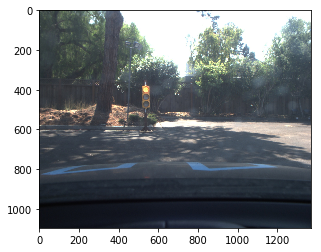

In [128]:
# Load test image
image = load_image('test_images/left0142.jpg') 
plt.imshow(image)
plt.show()

526.396434545517 375.8018157482147 565.2089087963104 491.2398269176483


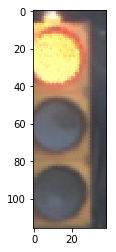

In [129]:
# Run inference
with tf.Session(graph=graph) as sess:
    tf_image_input = np.expand_dims(image, axis=0)
    detections, scores, boxes, classes = sess.run([
        sess.graph.get_tensor_by_name('num_detections:0'),
        sess.graph.get_tensor_by_name('detection_scores:0'),
        sess.graph.get_tensor_by_name('detection_boxes:0'),
        sess.graph.get_tensor_by_name('detection_classes:0')], 
        feed_dict={'image_tensor:0': tf_image_input})
    num_detections = int(np.squeeze(detections))
    for i in range(num_detections):
        classId = int(np.squeeze(classes)[i])
        if (classId != 10):
            continue
        score = np.squeeze(scores)[i]
        bbox = [float(v) for v in np.squeeze(boxes)[i]]
        if score > 0.3:
            #print ("Class: {}, Score: {}".format(classId, score))
            image = crop_image(image, bbox)
            plt.imshow(image)
plt.show()

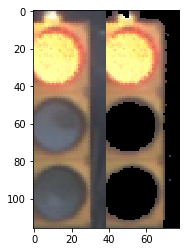

Output label is: 0


In [130]:
# Convert BGR to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# define range of bright color in HSV
lower = np.array([40,40,75])
upper = np.array([255,255,255])
# Threshold the HSV image to get only bright colors
mask = cv2.inRange(hsv, lower, upper)
# Bitwise-AND mask and original image
output = cv2.bitwise_and(image ,image, mask= mask)
# show the output image
plt.imshow(np.hstack([image, output]))
plt.show()

max_mean = 0
max_mean_index = -1
y_region_size = (int)(image.shape[0] / 3)
split_region = [y_region_size, 2 * y_region_size]
region_split = np.split(mask,split_region)
for i in range(3):
    region_mean = region_split[i].mean()
    if region_mean > max_mean:
        max_mean = region_mean
        max_mean_index = i
        
print("Output label is: " + str(max_mean_index))